# 说明文档

此文档为华为开发者大赛量子计算赛道决赛文档，其配套程序为parta.py与partb.py.

队伍: QuContractor

文档包括的内容有：

1. 试题分析
2. 解题过程
3. 程序说明
4. 结果分析
5. 后续考虑


In [2]:
from parta import *

# Part A 
## 1. 试题分析

### 命题题目
试题第一问要求根据实际gate误差，计算给定线路的fidelity。 由于需要考虑量子门操作用时，并且保证多量子门操作在同一时间完成，门之间需要用 I 门来填充。假设系统的qubit 数量为$N$，（暂时未考虑位置带来的衰减）则：

1. 增加一层仅含有单比特门的量子线路，需要N个量子门，保真度大概损失为 
$$ \Delta F = (F_i)^N\cdot\exp(-\frac{N*t_s}{T_0}) = $$ 
在 $N = 10$，线路长度 $L=1000$的情况下，$\Delta F =  0.993$.

2. 增加一层含有一个双量子门的量子线路，考虑2-bit-gate的操作时间，需要1个双量子门，$2（N-2）$个单量子们，保真度大概损失为 
$$ \Delta F = (F_2)\exp(-\frac{t_s}{T_0})\cdot(F_2)^{2N-4}\exp(-\frac{(2N-4)*t_s}{T_0}) = $$ 
在 $N = 10$，线路长度 $L=1000$的情况下，$\Delta F =  0.953$.

可见增加一层线路，尤其是CNOT,CZ对线路影响非常大。需要将电路尽可能缩短，在同一层中尽量对多个qubit进行操作。

### 给定gate

题目给定一组Clifford + T gates

### 线路分析

对线路分析发现，4个给定线路的基本结构相同，从 X gate 出发，对线路进行操作，初步预判为对初始态 |00001111> 进行某种演化操作。

通过观察，线路的大部分为某种对称结构的大量重复，其**基本单元**如下所示：

In [6]:
initial_circuit_1 = load_circuit('circuit1.txt')
initial_circuit_2 = load_circuit('circuit2.txt')
initial_circuit_1[6:21]

['Rx(1.570796326795) | Qureg[0]\n',
 'Rx(1.570796326795) | Qureg[1]\n',
 'Rx(1.570796326795) | Qureg[2]\n',
 'H | Qureg[3]\n',
 'CX | ( Qureg[0], Qureg[1] )\n',
 'CX | ( Qureg[1], Qureg[2] )\n',
 'CX | ( Qureg[2], Qureg[3] )\n',
 'Rz(12.538054518553) | Qureg[3]\n',
 'CX | ( Qureg[2], Qureg[3] )\n',
 'CX | ( Qureg[1], Qureg[2] )\n',
 'CX | ( Qureg[0], Qureg[1] )\n',
 'H | Qureg[3]\n',
 'Rx(10.995574287564) | Qureg[2]\n',
 'Rx(10.995574287564) | Qureg[1]\n',
 'Rx(10.995574287564) | Qureg[0]\n']

通过压缩，这样的线路可以分为9层，其中6层CNOT, 2层为前后的单比特操作，1层为中间的单比特Rz旋转。外面6+2层线路都可以用题目给定的gates表示出来，这些线路的fidelity损失为 $0.993^2\cdot0.953^6 = 0.738$.

中间一层Rz门，对一个小量$\theta = 0.0283$进行旋转，使用Solovay-Kitaev算法对Rz进行分解，在误差允许范围内，需要上百到几千个gate，按照100个门估算，仅运行这一个操作，带来的fidelity损失大概为$0.993^{100} = 0.45$.

根据以上分析，制约线路最大的两个部分分别是
1. 大量重复的线路中包含的CX门
2. 对$Rz(\theta)$进行SK分解引入的误差


### 物理过程

- 通过对线路运行，然后观察终态的分量，发现所有4个线路都是对|0000...1111>进行演化，制备类似|01010011>的superposition，演化产生类似Dicke state(非等权重叠加)(关于Dicke state可参考：
[arXiv:1904.07358](https://arxiv.org/abs/1904.07358))

- 该系统极有可能对应着一个费米子系统的演化过程。从初态的单粒子占据态出发，进行哈密顿量演化。该哈密顿量包含了单粒子跃迁和双粒子跃迁过程，并保持粒子数守恒。 我们在线路里观察到重复的$(AB)^N$, 对应着对哈密顿量演化做了Susuki-Trotter decomposition。 
 -- 猜测为费米系统，是由于线路出现了很多类似于$e^{\left(-\theta\cdot Z_0Z_1Z_2...Z_N \right)}$ 的项。在量子比特模拟费米子系统时，通过jordan-wigner 变换，会引进这种项。

- 如果该线路为模拟费米子系统。那线路优化的意义在于，通过近似等价但较浅的线路，可以在噪声量子芯片上，以较高的保真度运行，从而探索量子多体的难题。

In [3]:
run_circuit(initial_circuit_1, 4, cut_off=0.001)

OrderedDict([('0011', (0.993592444257794+0j)),
             ('1100', (0.11302236377734481+0j))])

对于上面所示的基本线路，通过分析可以发现，中间CNOT部分线路操作表示将|0>|1>|2>与|3>进行纠缠，进行Z方向$theta=0.028$的演化。circuit1中这个线路，代表着双粒子产生-湮灭的演化，将|0011>态制备到|1100>分量。

通过观察，所有的基本单元都可以表示为类似形式：
$$ e^{\left(-\theta\cdot Z_0Z_1Z_2Z_3 \right)}$$

根据具体操作不同，该线路分别可以表示单粒子和双粒子的产生、湮灭，通过一系列这样的重复操作，最终将初始态|00001111>制备成Dickd states的叠加态，即线路的演化为：
$$ U = U_1e^{-iH_1(\theta_1)}U_1^{\dagger}\cdot U_2e^{-iH_2(\theta_2)}U_2^{\dagger} $$

num of Rz blocks:=  8


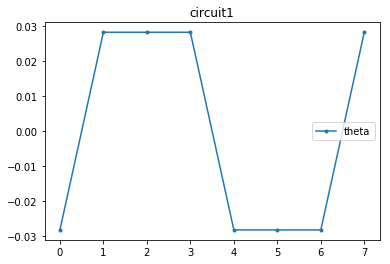

num of Rz blocks:=  128


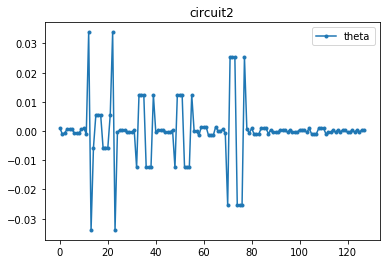

num of Rz blocks:=  564


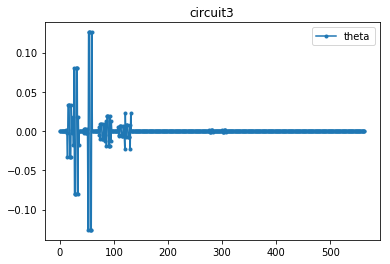

num of Rz blocks:=  400


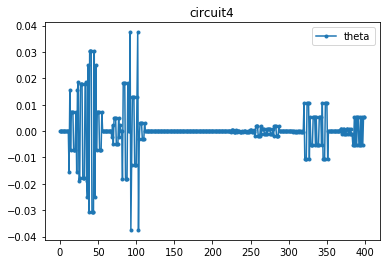

In [5]:
import matplotlib.pyplot as plt

''.join(['xxx','234'])
for ii in range(4):
    thetas = []
    initial_circuit_1 = load_circuit(''.join(['circuit',str(ii+1),'.txt']))
    [circuit_blocks, get_circuit_cmd] = find_Rz_block(initial_circuit_1)
    for iii in range(len(get_circuit_cmd)):
        thetas.append(get_circuit_cmd[iii][0])
    print('num of Rz blocks:= ',len(thetas))
    fig = plt.figure()
    plt.title(''.join(['circuit',str(ii+1)]))
    plt.plot(thetas,'.-',label = 'theta')
    plt.legend()
    plt.show()

## 2. 解题过程

### Fidelity 计算

题目中要求对线路进行fidelity计算，以I门填充不同线路之间的时间差。

1. 对每一个qubit的时间和空间坐标进行编号。

2. 根据线路顺序，先将每一行circuit的文本进行读取，取得gate, qubit, parameter等参数。（也可以通过HiQ自带的程序，对线路进行操作并转化为command格式。）

3. 若a-qubit 有单比特操作，则根据题目公式计算fidelity，如果gate为题目给定之外，则按照0.9995计算。同时a-qubit的时间坐标+1.
```
f = F_dict[str(gate)]*(1 - qbit[0]*0.0001) * math.exp(-t_step[qbit[0]]*T_decay)
```

4. 对于a,b-qubit有双比特门操作，首先判断a,b的时间坐标进行比较，选取最大的进行同步。对于时间坐标比较小的比特，填充一定数量的I门，并连乘所有的I门fidelity。然后计算此时间空间位置上双比特门的fidelity。题目给定之外的gate,以0.9944来计算。最后a,b-qubit时间坐标+2.
```  
        f = 1.0
        t_max = t_step[qbit].max()
        for bit_i in qbit:
            dt = t_max - t_step[bit_i] 
            f *= (F_dict['I']*(1 - bit_i*0.0001)) ** dt
            f *= math.exp(- T_decay * dt*(t_max + t_step[bit_i] )/2 )
            t_step[bit_i] = t_max
        f *= F_dict[str(gate)]*(1 - qbit[0]*0.0001) * math.exp(-t_step[qbit[0]]*T_decay)
        t_step[qbit] += 3
```
5. 对于3、4比特门进行类似操作。注意qubit时间坐标+3，+4

6. 根据选择，确定是否需要最后同时计算measurement。如果是对于最后同时measurement，将所有电路同步，以I填充。否则，可以看作运行完线路即测量。

### 线路合并

结合上面对于线路误差的分析，我们首先对不同的基本单元（也就是不同qubit的产生-湮灭）进行归类合并，然后演化获取系统终态。仍然以circuit1为例分析，由于基本单元的对称型结构，通过函数很容易对其进行分类、归纳。共有8个block结构:

In [7]:
initial_circuit_1 = load_circuit("circuit1.txt")
[circuit_blocks, circuit_cmd] = find_Rz_block(initial_circuit_1);
print('number of block units: ',len(circuit_blocks))
circuit_blocks[0]

number of block units:  8


[12.538054518553,
 ['Rx(1.570796326795) | Qureg[0]\n',
  'Rx(1.570796326795) | Qureg[1]\n',
  'Rx(1.570796326795) | Qureg[2]\n',
  'H | Qureg[3]\n',
  'CX | ( Qureg[0], Qureg[1] )\n',
  'CX | ( Qureg[1], Qureg[2] )\n',
  'CX | ( Qureg[2], Qureg[3] )\n',
  'Rz(12.538054518553) | Qureg[3]\n',
  'CX | ( Qureg[2], Qureg[3] )\n',
  'CX | ( Qureg[1], Qureg[2] )\n',
  'CX | ( Qureg[0], Qureg[1] )\n',
  'H | Qureg[3]\n',
  'Rx(10.995574287564) | Qureg[2]\n',
  'Rx(10.995574287564) | Qureg[1]\n',
  'Rx(10.995574287564) | Qureg[0]\n']]

如下，对这8个block进行归类，其中第一列代表这个线路单元的Rx, H gates所涉及到的qubits（未包括CNOT这类)，第二列是Rx(pi/2)或者Rx(-pi/2)所涉及的qubits, 第三列是H-gate涉及的qubit，第四列是线路中心的Rz($\theta$)所涉及qubit。最后一列是Rz旋转的$\theta$。根据$\theta$与$2\pi$夹角的大小，将$\theta$化为+-表示。

In [8]:
[circuit_index, count_circuit_index] = find_block_index(circuit_cmd)
circuit_index

[[[0, 1, 2, 3, '-'], [0, 1, 2], [3], [3], -0.028316095806172115],
 [[0, 1, 2, 3, '+'], [0, 2, 3], [1], [3], 0.028316095806],
 [[0, 1, 2, 3, '+'], [2], [0, 1, 3], [3], 0.028316095806],
 [[0, 1, 2, 3, '+'], [1, 2, 3], [0], [3], 0.028316095806],
 [[0, 1, 2, 3, '-'], [0], [1, 2, 3], [3], -0.028316095806172115],
 [[0, 1, 2, 3, '-'], [0, 1, 3], [2], [3], -0.028316095806172115],
 [[0, 1, 2, 3, '-'], [1], [0, 2, 3], [3], -0.028316095806172115],
 [[0, 1, 2, 3, '+'], [3], [0, 1, 2], [3], 0.028316095806]]

上面的线路表示对粒子在$\sigma_z$方向的产生和湮灭。对与初始态|0011>，这代表两个粒子的态从qubit_1,qubit_2的转移，得到的dicke state 包含|1100>分量。根据线路的制备，只有当$\theta>0$与$\theta<0$成对出现，初始态的粒子数才保持守恒。

根据以上观察，我们将同一类基本单元做归类,对于同样效果的演化，我们将他们归并在一起，其中的Rz($\theta$)为相似$\theta$的相加操作，对于circuit1,通过这样的合并，8个基本的线路单元可以合并为同一类两种线路，分别对应$\theta>0$与$\theta<0$，两个线路实现了从|0011> 到 |1100>分量的演化:

In [ ]:
count_circuit_index

[[[0, 1, 2, 3, '-'], 4, -0.11326438322468846, 0],
 [[0, 1, 2, 3, '+'], 4, 0.113264383224, 1]]

### SK 分解

线路合并后的演化，变为了对两个小量$\theta=\pm0.113$在Rz方向上的演化。在这里我们通过Solovay-Kitaev算法对Rz($\theta$)分解为Clifford gates。我们采用的算法基于文献 arXiv:1212.6964 及相关代码，相对于原来递归的SK算法，可以用更少的门的数量来达到较高的精度。我们直接用到 $Rz(\pm pi/2^k)$的分解，其中k最大取7.

Solovay-Kitaev 原理证明了可以通过一系列基本门，根据给定的精度来近似一个任意的演化操作U。进行过上面合并操作的线路，其$\theta$相对变大，使用Solovay-Kitaev算法对Rz进行分解，可以在一定误差范围内，尽量保持线路的长度可控，在之后的优化过程中，根据线路来进行精度控制。

### 线路简化a

通过SK分解之后的线路，其本身结构存在大量可以缩并的简化，例如 HH=I, HRxH=Rz。根据线路的可对易关系以及推导，根据题目给定的Ref2以及相关优化论文，我们定义了一系列对线路进行合并，排序的函数，基本的原则为：
* 保证线路的严格性，仅支持可以严格成立的简化
* 尽量在同一层进行多个不同qubit的single-gate操作，减少线路层数

### 线路简化 b

在进行过上述优化后，使用ProjectQ自带的优化方案进行，主要使用cengines.LocalOptimizer，TagRemover等.
>>
class projectq.cengines.LocalOptimizer()
>>
LocalOptimizer is a compiler engine which optimizes locally (merging rotations, cancelling gates with their inverse) in a local window of user- defined size.
>>
It stores all commands in a dict of lists, where each qubit has its own gate pipeline. After adding a gate, it tries to merge / cancel successive gates using the get_merged and get_inverse functions of the gate (if available). For examples, see BasicRotationGate. Once a list corresponding to a qubit contains >=m gates, the pipeline is sent on to the next engine.

### 简化流程
根据以上各模块，线路的简化流程如下：

1. 对原始线路init_circuit进行基本单元的分割
2. 对同一类的线路单元，即单粒子或双粒子（或更普遍的多粒子）的转移，进行合并。
3. 使用Solovay-Kitaev 对合并后的线路进行Rz($\theta$)的基本门分解。同时将线路CX门转换成H-CZ-H门。
4. 依次使用*线路简化a*和*线路简化b*来对生成线路化简。

## 3. 程序说明

本章对定义的函数依次进行说明，其中有些函数功能已经在上面介绍

```def single_circuit_fidelity(t_step, circ, F_dict, fill_until_measure = False):```
* 函数输入量为所有qubit的当前时间坐标，当前运行线路，gate fidelity 的dict定义。
* 函数返回值为运行单行线路后的fidelity，运行后的时间坐标
* 具体逻辑定义请参见上面"Fidelity计算"

```def calculate_circuit_fidelity(qubits, circuit):```
* 输入值为qubit数目，输入的一段量子线路
* 返回值为线路运行后的fidelity

In [ ]:
calculate_circuit_fidelity?

```def find_Rz_block(input_circuit, Rz_min = 0.00):```
* 对初始线路，寻找线路中所有的基本单元操作
* 输入值为初始线路，需求的$\theta$的小量截断
* 返回值为基本单元block的列表，其中元素个数为block个数，单个列表元素第一个为$\theta$的值，第二个为block的线路。


In [ ]:
[circuit_blocks, circuit_cmd] = find_Rz_block(initial_circuit_1)
circuit_blocks[0]

[12.538054518553,
 ['Rx(1.570796326795) | Qureg[0]\n',
  'Rx(1.570796326795) | Qureg[1]\n',
  'Rx(1.570796326795) | Qureg[2]\n',
  'H | Qureg[3]\n',
  'CX | ( Qureg[0], Qureg[1] )\n',
  'CX | ( Qureg[1], Qureg[2] )\n',
  'CX | ( Qureg[2], Qureg[3] )\n',
  'Rz(12.538054518553) | Qureg[3]\n',
  'CX | ( Qureg[2], Qureg[3] )\n',
  'CX | ( Qureg[1], Qureg[2] )\n',
  'CX | ( Qureg[0], Qureg[1] )\n',
  'H | Qureg[3]\n',
  'Rx(10.995574287564) | Qureg[2]\n',
  'Rx(10.995574287564) | Qureg[1]\n',
  'Rx(10.995574287564) | Qureg[0]\n']]

```def find_block_index(circuit_cmds):```
* 对所有的Block进行归纳整理，将同一类基本单元做归类,对于同样效果的演化，我们将他们归并在一起，其中的Rz($\theta$)为相似$\theta$的相加操作
* 输入值为上个函数的block list
* 输出为block分类

In [ ]:
[circuit_index, count_circuit_index] = find_block_index(circuit_cmd)
circuit_index

[[[0, 1, 2, 3, '-'], [0, 1, 2], [3], [3], -0.028316095806172115],
 [[0, 1, 2, 3, '+'], [0, 2, 3], [1], [3], 0.028316095806],
 [[0, 1, 2, 3, '+'], [2], [0, 1, 3], [3], 0.028316095806],
 [[0, 1, 2, 3, '+'], [1, 2, 3], [0], [3], 0.028316095806],
 [[0, 1, 2, 3, '-'], [0], [1, 2, 3], [3], -0.028316095806172115],
 [[0, 1, 2, 3, '-'], [0, 1, 3], [2], [3], -0.028316095806172115],
 [[0, 1, 2, 3, '-'], [1], [0, 2, 3], [3], -0.028316095806172115],
 [[0, 1, 2, 3, '+'], [3], [0, 1, 2], [3], 0.028316095806]]

```def circuit_contractor_simplify(initial_circuit,circuit_index,count_circuit_index, circuit_blocks, theta_min = 1E-2):```
* 根据上面的Block list，对同类block进行合并，并按照原来线路结构构建等价的单元线路
* 输入值为原始线路，进行后续计算的$\theta$最小值
* 返回值为花间之后的线路


```def circuit_sk_simplify(circuit_in, sk_gate = 'Rz', sk_cutoff = 6):```
* 将线路中作为较小量的Rz($\theta$)做SK展开
* 输入为合并后的线路，以及参数控制
* sk_cutoff 控制着最小的角度单位$=\frac{\pi}{2^{sk_cotoff}}$
* 输出为题目要求的基本量子门

In [ ]:
contract?

## 4. 结果分析

在我们的优化中，有如下几个参数可以控制输出的线路长度与精度：
1. $\theta$_$min$: 控制线路组合时最小的Rz($\theta$)的角度，小于此值的Rz演化被丢弃，以减少线路长度。
2. SK_cutoff: 控制Rz分解时SK的精度，约大代表越高的精度。此值默认为5，即将$\theta$向最小角度单元$\theta_0 = \pi/2^5$近似。
3. use_pre：控制线路组合时是使用原线路结构，还是程序自动构建简化结构。此值默认为True,精度相对较高，但是使用较多的CNOT门。

In [ ]:
run parta.py

依次对线路1，2，3，4进行分析，下面函数输出每一步中circuit的总长度，每一步之后的fedelity以及最后优化的fidelity。 

通过对比可以看出，线路在合并之后(after block)，总长度大概有几十倍的缩短，同时fidelity增加到一定程度。
通过SK分解之后，线路长度又增长数倍，最后再次经过优化，线路的总长度有所缩减，同时fidelity升高。

通过分析我们得到，制约线路的瓶颈主要在于对Rz($\theta$)的量进行SK分解。
相对其他系统，离子阱系统对Rz($\theta$)任意角度的旋转更加方便。下面的partB我们考虑离子阱系统进行线路分析。

In [7]:
calculate_circuit_result('circuit1',4)

time for init    :  0.10289788246154785
time simplify    :  0.14014196395874023 

circuit1 

theta_min= 0.05    sk_cutoff= 5
Length, initial  : 130
Length, blocks   : 44
Length, after_SK : 169
Length, final    : 165


fidelity, initial  : 0.41128481113228776
fidelity, blocks   : 0.8541962746510597
fidelity, after_SK : 0.24506695227932757
fidelity, final    : 0.2528543696546446


Overlap, initial  : 0.999999999999992
Overlap, blocks   : 0.9999999999999947
Overlap, after_SK : 0.9995947905224675
Overlap, final    : 0.9995947905224675


In [4]:
calculate_circuit_result('circuit2',12,theta_min = 5*1E-2, sk_cutoff = 5, use_pre=False)

time for init    :  1.9387519359588623
time simplify    :  0.1453862190246582 

circuit2 

theta_min= 0.05    sk_cutoff= 5
Length, initial  : 2556
Length, blocks   : 62
Length, after_SK : 187
Length, final    : 183


fidelity, initial  : 0.0
fidelity, blocks   : 0.8099691463583868
fidelity, after_SK : 0.18095149456140672
fidelity, final    : 0.18745024912846134


Overlap, initial  : 0.999999999999883
Overlap, blocks   : 0.9921638457434072
Overlap, after_SK : 0.9920769452486321
Overlap, final    : 0.9920769452486321


In [8]:
calculate_circuit_result('circuit3',14, theta_min = 3*1E-2, sk_cutoff = 6,use_pre=False)

time for init    :  9.334735870361328
time simplify    :  0.6815629005432129 

circuit3 

theta_min= 0.03    sk_cutoff= 6
Length, initial  : 12694
Length, blocks   : 204
Length, after_SK : 1036
Length, final    : 1004


fidelity, initial  : 0.0
fidelity, blocks   : 0.11923152086128752
fidelity, after_SK : 1.616963919738046e-25
fidelity, final    : 1.6782567094594805e-24


Overlap, initial  : 0.9999999999994691
Overlap, blocks   : 0.9968524580444572
Overlap, after_SK : 0.9909461793882388
Overlap, final    : 0.9909461793882384


In [6]:
calculate_circuit_result('circuit4',14, theta_min = 5*1E-3, sk_cutoff = 6)

time for init    :  6.415438175201416
time simplify    :  0.9842824935913086 

circuit4 

theta_min= 0.005    sk_cutoff= 6
Length, initial  : 8150
Length, blocks   : 1190
Length, after_SK : 2120
Length, final    : 1500


fidelity, initial  : 0.0
fidelity, blocks   : 1.3839918446305826e-108
fidelity, after_SK : 5.053183805559307e-286
fidelity, final    : 1.611177706597269e-113


Overlap, initial  : 0.999999999999607
Overlap, blocks   : 0.9900391318447084
Overlap, after_SK : 0.9838602415134851
Overlap, final    : 0.9838602415134846


## 5. 优化的进一步考虑
线路里的每个block对应着一个单粒子或双粒子跃迁过程，其幅度有$Rz(\theta)$ 决定。
几乎所有跃迁都从初始占据态出发。对于$\theta$ 非常小的情况，SK分解代价较高。但可以从非初始占据态出发来进行跃迁，从而可以让$\theta$取值较大。
对于演化出的波函数具备很多相同但非常小量的分量的情形，该方法更为有效。
以circuit4为例，主要涉及如下的跃迁过程： ((a,b) -> (c,d) 表示粒子从a和b跃迁到 c和d)
``` 
(6,7) -> (10,11)   |    (6,7) -> (10,11) 

(4,5) -> (10,11)   |    (4,5) -> (6,7)

(4,5) -> (12,13)   |   (6,7) -> (12,13)
```
左边表示从初始占据态出发的跃迁，右边表示等价的跃迁过程。
右边的表示的好处为，可以取较大的$\theta$，如下所示：

(每一行倒数第二位表示$\theta$的取值。特别地，$0.788506933877375=pi/4$,即对应Z/2门，不需要做SK分解)

原来的跃迁过程：
```
[[[6, 7, 10, 11, '-'], 4, -0.1220191661806922, 26], 

[[6, 7, 10, 11, '+'], 4, 0.12201916618, 27],

[[4, 5, 10, 11, '-'], 4, -0.07174851260869275, 14],

[[4, 5, 10, 11, '+'], 4, 0.071748512608, 15],

[[4, 5, 12, 13, '-'], 4, -0.07238333520069062, 56],

[[4, 5, 12, 13, '+'], 4, 0.072383335204, 57]]
```

优化后的跃迁过程：
```
[[[6, 7, 10, 11, '-'], 4, -0.15879321099344493, 26],

 [[6, 7, 10, 11, '+'], 4, 0.15879321099344493, 27],
 
 [[4, 5, 6, 7, '-'], 4, -0.6923610919268163, 14],
 
 [[4, 5, 6, 7, '+'], 4, 0.6923610919268163, 15],
 
 [[6, 7, 12, 13, '-'], 4, -0.788506933877375, 56],
 
 [[6, 7, 12, 13, '+'], 4, 0.788506933877375, 57]]
 ```

# Part B 
##  1. 系统分析

在该部分我们考虑离子阱系统，主要包含两个内容：
- 基于离子阱系统的噪声量子线路的优化。通过离子阱的连续的旋转门，以及量子比特的全连接特点，我们在a部分的线路的优化问题中，取得了优越得多的结果。
- 基于离子阱系统，提出哈密顿量演化的优化，作为今后进一步的探索方向。



### 离子阱系统的特点：
1.	单比特和双比特的高保真度。其中，XX 门是 离子阱特有的量子门。
2.	连续的单比特旋转门
3.	全连接性
4.	离子间的相互作用，天然适合模拟量子多体。


离子阱相关参数：
```
    Fidelity_dict = {'I': 0.9995,
              'X': 0.995,
              'Y': 0.995,
              'Z': 0.995,
              'H': 0.995,
              'T': 0.995,
              'Rx': 0.995,
              'Ry': 0.995,
              'Rz': 0.995,
              'CZ': 0.99,
              'XX': 0.99,
              'any1':0.995,
              'any2':0.99}
```
参考了arXiv:1903.08181(2019), C. Monroe

In [1]:
run partb.py

The initial fidelity for circuit 1 is 0.32358332917672367
The fidelity after compilation is: 0.7740114774003369
Run time for compling circuit 1 is 0.010161638259887695


继续对a部分的各线路进行优化。采用的分析在a部分已有论述。
离子阱系统在线路优化上：
1. 离子阱可以直接用连续的旋转门, 克服SK分解带来线路深度增长，保真度急剧下降的问题。
2. 离子阱的XX门也可以得到很好的利用。单粒子跃迁对应的线路模块，可以用 $e^{\theta X_i Y_j}$ 来描述。它可以分解为 
$[e^{\theta X_i Y_j}=e^{pi/4 X_i X_j}e^{i\theta Z_j}e^{-pi/4 X_i X_j}$，其中，$e^{pi/4 X_i X_j}$ 为half-entangle 门, 从而需要更少的门。
3. 离子阱具有全连接性。对于十几个比特内的系统，可以在任意两个比特间进行两比特门的高保真度操作。


In [2]:
calculate_circuit_result('circuit1',4)

time for init    :  0.11549234390258789
time simplify    :  0.012599945068359375 

circuit1 

theta_min= 0.05
Length, initial  : 130
Length, blocks   : 44
Length, final    : 36


fidelity, initial  : 0.32358332917672367
fidelity, blocks   : 0.740284348825009
fidelity, final    : 0.7740114774003369


Overlap, initial  : 0.999999999999992
Overlap, blocks   : 0.9999999999999947
Overlap, final    : 0.9999999999999947


In [3]:
calculate_circuit_result('circuit2',12, theta_min = 1E-1)

time for init    :  1.9394173622131348
time simplify    :  0.05457949638366699 

circuit2 

theta_min= 0.1
Length, initial  : 2556
Length, blocks   : 86
Length, final    : 78


fidelity, initial  : 0.0
fidelity, blocks   : 0.2844639234835149
fidelity, final    : 0.3062244330277539


Overlap, initial  : 0.999999999999883
Overlap, blocks   : 0.9921638457434072
Overlap, final    : 0.9921638457434072


In [4]:
calculate_circuit_result('circuit3',14, theta_min = 1E-1)

time for init    :  9.168016910552979
time simplify    :  0.13720417022705078 

circuit3 

theta_min= 0.1
Length, initial  : 12694
Length, blocks   : 152
Length, final    : 124


fidelity, initial  : 0.0
fidelity, blocks   : 0.13200936796877344
fidelity, final    : 0.17751738778260182


Overlap, initial  : 0.9999999999994691
Overlap, blocks   : 0.9916120566113564
Overlap, final    : 0.9916120566113564


In [5]:
calculate_circuit_result('circuit4',14, theta_min = 5E-3)

time for init    :  6.376171350479126
time simplify    :  0.49334216117858887 

circuit4 

theta_min= 0.005
Length, initial  : 8150
Length, blocks   : 1190
Length, final    : 1002


fidelity, initial  : 0.0
fidelity, blocks   : 6.768271584378434e-106
fidelity, final    : 6.186810803695222e-96


Overlap, initial  : 0.999999999999607
Overlap, blocks   : 0.9900391318447084
Overlap, final    : 0.9900391318447082


##  2. 基于哈密顿量演化的量子线路优化

**Hiq有TimeEvolution的方法，构造hamiltonian 演化很方便，可以进一步在该基础上考虑加噪声，以及评估体系的保真度**


单比特和双比特量子门构建的量子线路是量子计算的标准模型之一。另一类是基于哈密顿量的演化，目前相关的包括不限于：

- 设计系统的哈密顿量，用于量子模拟
- 优化问题。
     1. 如量子退火算法，把问题的解映射为伊辛模型的基态解，通过绝热演化来求基态，通过量子遂穿效应来加速。
     2. Quantum Approximate Optimization Algorithm 
    
- 变分量子求解器。通过哈密顿量演化来制备变分量子态，通过优化演化时间，哈密顿量的参数来制备待解系统的基态。 (Nature 569, 355–360 (2019))

- 制备纠缠态。如最近的20比特的薛定猫态(GHZ)，即通过 $H=(\sum_iZ_i)^2$ 的演化来完成，该哈密顿量高度非局域，演化中可以同时作用于所有比特，相对于单比特和双比特的序列操作，大大减少了时间，从而可以在退相干前制备出多比特纠缠态。(Science 365, 574–577 (2019))

### 举个栗子：
作为一个直观的例子来显示哈密顿演化的优势，在对氢分子H2的哈密顿量做VQE求解时，通过gate-based表述需要进行如下的演化：
```
    wf = eng.allocate_qureg(2)
    X | wf[0]
    Rx(-np.pi/2) | wf[0]
    Ry(np.pi/2) | wf[1]
    CNOT |  (wf[1],wf[0])
    Rz(theta) | wf[0]
    CNOT |  (wf[1],wf[0])
    Rx(np.pi/2) | wf[0]
    Ry(-np.pi/2) | wf[1]
    eng.flush()
```
而在用基于演化的方式，例如在HiQ的官方文档中，可以更简洁的构建等效的量子计算过程。值得指出的是，$e^{\theta X_0 Y_1}$ 这种演化在离子阱体系里，方便用XX门来实现(PRX 8, 031022 (2018))。
```
    wavefunction = eng.allocate_qureg(2)
    X | wavefunction[0]
    ansatz_op = QubitOperator('X0 Y1')
    TimeEvolution(theta, ansatz_op) | wavefunction
    eng.flush()
```

由此可见，哈密顿量演化不仅仅只是做量子模拟，而且可以作为计算资源来做优化和求解系统的问题。

那么，在真实噪声环境下，通过哈密顿量演化进行量子计算，需要考虑的问题：
- 如何描述该系统的噪声性质？
- 如何评估该系统的好坏？ 
- 如何优化哈密顿量的形式及其参数，以及演化时间，从而以较高保真度完成计算任务？

离子阱系统天然存在离子间的相互作用，且可调节为短程还是长程。利用它高度可控的性质，调整哈密顿量及演化时间，可用于不同任务。 
我们在trapped-ion evolution里考虑了交替演化：$\prod_te^{iH_1\alpha_t}e^{H2 \beta_t}$. 其中 $H_1$为伊辛模型，其演化产生纠缠；$H_2=\sum_i \Delta_i X_i$ , 可以对单个离子打入不同激光而调节。  该演化可进一步用于优化或者变分量子求解等问题。


描述这样一个系统的演示程序如下面所示：

```
def run_ham_evolution(B,hs,nqubit=6,ts=[[0.1,0.2],[0.2,0.1]],layer=2,cut_off=1e-4):
    eng = MainEngine()
    Qureg=eng.allocate_qureg(nqubit)
    
    #alternating operator
    for i in range(layer):
        ham1=construct_ham_entangler(B,nqubit)
        ham2=construct_ham_local(hs[:,i],nqubit)
        TimeEvolution(ts[i][0],ham1) | Qureg
        TimeEvolution(ts[i][1],ham2) | Qureg
        
    eng.flush()
    state =eng.backend.cheat()
    All(Measure) |  Qureg
    return state
```
```
def construct_ham_entangler(B,nqubit):
    ham=0*QubitOperator(one_pauli('X',1))
    for i in range(nqubit):
        for j in range(i):
            ham += 1*QubitOperator(two_pauli(['X','X'],[i,j]))
        ham+=B*QubitOperator(one_pauli('Z',i))
    return ham

def construct_ham_local(h,nqubit):
    ham=0*QubitOperator(one_pauli('X',1))
    for i in range(nqubit):
        ham+=h[i]*QubitOperator(one_pauli('Z',i))
    return ham
```


## 离子阱系统影响保真度的评估：
1. 演化时间长 -> 保真度下降
2. 哈密顿量涉及的比特数
3. 两两相互作用的离子间的平均距离 
4. 在不同哈密顿量之间切换导致的系统弛豫